# Life Expectancy Prediction: Machine Learning Pipeline
This notebook develops a robust **Random Forest Regressor** to predict life expectancy using a multi-stage preprocessing pipeline.

### Key Features:
* **Time-Series Interpolation:** Fills gaps within country records.
* **Geospatial Engineering:** Converts country names to Continents.
* **Custom Imputation:** Combines grouped-median and global-median strategies.

## 1. Environment Setup and Imports
We utilize `sklearn` for the core pipeline architecture and `feature_engine` for specialized DataFrame-native transformations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import DropFeatures
from feature_engine.transformation import LogCpTransformer
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import MeanMedianImputer
import sklearn
import preprocessors as pp
import joblib


# Force Scikit-Learn to return Pandas DataFrames
sklearn.set_config(transform_output="pandas")

## 2. Data Loading and Initial Cleaning
We strip trailing spaces from column names and sort by **Country** and **Year** to ensure chronological consistency.

In [2]:
df = pd.read_csv("../Life Expectancy Data.csv")
df.columns = df.columns.str.strip()
df.dropna(subset=['Life expectancy'], inplace=True)

# Crucial: Sort before split to maintain time-series logic for interpolation
df = df.sort_values(['Country', 'Year'])

## 3. Training/Test Split
We split the data before applying transformations to prevent data leakage.

In [3]:
X = df.drop('Life expectancy', axis=1)
y = df['Life expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Pipeline Construction
The pipeline handles everything from feature generation to final regression.

In [4]:
num_vars_with_na = ['Alcohol', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 
                    'Diphtheria', 'GDP', 'Population', 'Schooling']
drop_vars = ["Year", "Country", 'Hepatitis B', 'Polio', 'Diphtheria', 
             "infant deaths", "percentage expenditure", "thinness 5-9 years", 
             "Income composition of resources", 'thinness  1-19 years']
log_plus_one_vars = ['under-five deaths', 'Population', 'Measles', 'GDP']
binarize_vars = ['HIV/AIDS']
ohe_vars = ['Status', 'Continent']
imm_vars = ['Hepatitis B', 'Polio', 'Diphtheria']

pipe = Pipeline([
    ('continent_gen', pp.ContinentConverter(country_col='Country')),
    ('by_country_imputer', pp.CountryInterpolator(variables=num_vars_with_na)),
    ('group_imputer', pp.GroupedMedianImputer(variables=num_vars_with_na)),
    ('final_imputer', MeanMedianImputer(imputation_method='median', variables=num_vars_with_na)),
    ('imm_score', pp.ImmunizationFeatureCreator(variables=imm_vars)),
    ('binarizer', pp.Binarizer(variables=binarize_vars)),
    ('log', LogCpTransformer(variables=log_plus_one_vars, C=1)),
    ('drop', DropFeatures(features_to_drop=drop_vars)), 
    ('one_hot', OneHotEncoder(variables=ohe_vars, drop_last=True)),
    ('robust_scaler', RobustScaler()),
    ('reg', RandomForestRegressor(n_estimators=300, random_state=42))
])

## 5. Model Training & Evaluation

In [5]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"Final R2 Score: {r2_score(y_test, y_pred):.4f}")

Final R2 Score: 0.9602


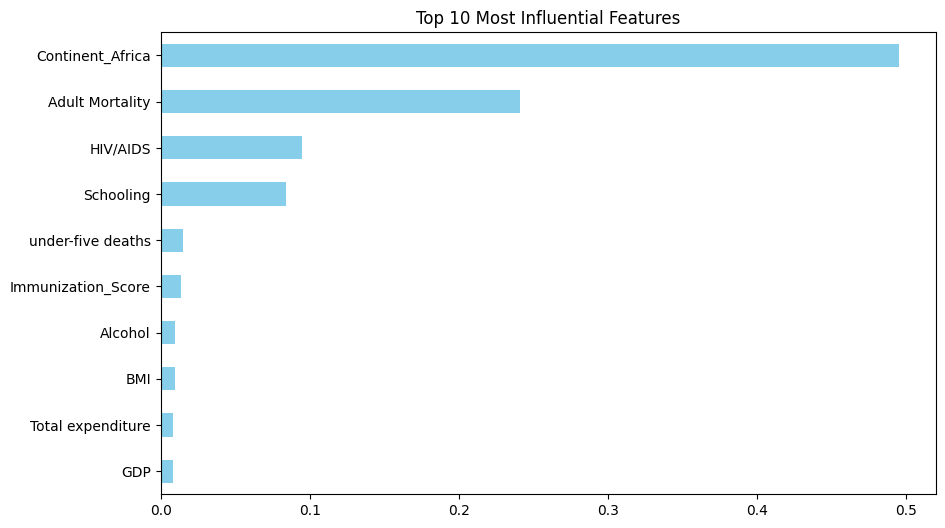

In [6]:
# 1. Get the trained model
model = pipe.named_steps['reg']

# 2. Transform the data through everything EXCEPT the last step (the regressor)
# This gives us a DataFrame where we can just look at the columns
X_transformed = pipe[:-1].transform(X_test.head(1))
feature_names = X_transformed.columns

# 3. Create and Plot
importances = pd.Series(model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh', color='skyblue').invert_yaxis()
plt.title('Top 10 Most Influential Features')
plt.show()

In [7]:
# Exporting the trained pipeline object
joblib.dump(pipe, 'life_expectancy_v1.joblib')

# Verify by loading and checking the R2 on test set one last time
model_check = joblib.load('life_expectancy_v1.joblib')
check_score = model_check.score(X_test, y_test)
print(f"Exported Model Verification Score: {check_score:.4f}")

Exported Model Verification Score: 0.9602
